# PyTorchによる基本的な訓練の流れ

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/py-img-gen/python-image-generation/blob/main/notebooks/2-2_pytorch.ipynb)

## 準備

In [1]:
!pip install -qq py-img-gen

In [2]:
import pathlib

current_dir = pathlib.Path.cwd()
project_dir = current_dir / "data" / "pytorch-introduction"

project_dir.mkdir(parents=True, exist_ok=True)

## PyTorch の導入

- 参考: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

## データの扱い方

### データのダウンロードと読み込み

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

data_dir = project_dir / "dataset"

train_data = datasets.FashionMNIST(
    root=data_dir,
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=ToTensor(),
)

### データローダーの作成

In [4]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(
    train_data, batch_size=batch_size
)
test_dataloader = DataLoader(
    test_data, batch_size=batch_size
)

### データローダーを用いたミニバッチの作成

In [5]:
(Xs, ys) = next(iter(train_dataloader))
print(f"Shape of Xs [N, C, H, W]: {Xs.shape}")
print(f"Shape of ys: {ys.shape} {ys.dtype}")

Shape of Xs [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of ys: torch.Size([64]) torch.int64


### 訓練データの可視化

In [6]:
from py_img_gen.datasets import get_fashion_mnist_classes

classes = get_fashion_mnist_classes()
print(classes)

('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')


Text(0.5, 1.0, 'Class: 9 (Ankle boot)')

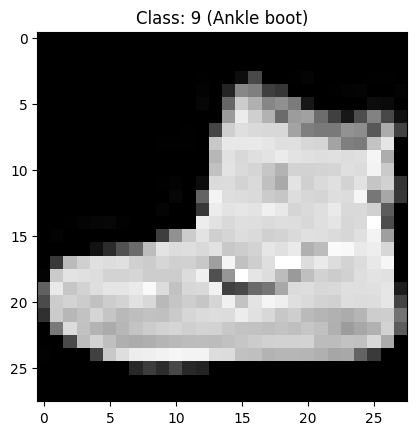

In [7]:
import matplotlib.pyplot as plt

idx = 0
# shape (X): (1, 28, 28) -> (28, 28)
X, y = Xs[idx].squeeze(dim=0), ys[idx]

fig, ax = plt.subplots()
ax.imshow(X, cmap="gray")
ax.set_title(f"Class: {y} ({classes[y]})")

## モデルの構築

### デバイスの取得

In [8]:
import torch

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


## モデルの定義

In [9]:
from torch import nn


class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)


model = NeuralNetwork()
model = model.to(device)

## モデルパラメータの最適化

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

### モデルの訓練方法の定義

In [11]:
def train(
    dataloader: DataLoader,
    model: NeuralNetwork,
    loss_fn: nn.CrossEntropyLoss,
    optimizer: torch.optim.SGD,
) -> None:
    model.train()  # モデルを訓練モードに

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # 予測誤差の計算
        pred = model(X)
        loss = loss_fn(pred, y)

        # 逆伝播の実行
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 != 0:
            continue

        current = (batch + 1) * len(X)
        size = len(dataloader.dataset)
        print(
            f"loss: {loss.item():>7f} "
            f"[{current:>5d}/{size:>5d}]"
        )

### モデルの評価方法の定義

In [12]:
@torch.no_grad()
def test(
    dataloader: DataLoader,
    model: NeuralNetwork,
    loss_fn: nn.CrossEntropyLoss,
) -> None:
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (
            (pred.argmax(1) == y)
            .type(torch.float)
            .sum()
            .item()
        )
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, "
        f"Avg loss: {test_loss:>8f} \n"
    )

### モデルの訓練と評価の実行

In [13]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.294302 [   64/60000]
loss: 2.287944 [ 6464/60000]
loss: 2.267821 [12864/60000]
loss: 2.268955 [19264/60000]
loss: 2.249670 [25664/60000]
loss: 2.218377 [32064/60000]
loss: 2.227860 [38464/60000]
loss: 2.190378 [44864/60000]
loss: 2.195681 [51264/60000]
loss: 2.162417 [57664/60000]
Test Error: 
 Accuracy: 33.0%, Avg loss: 2.156033 

Epoch 2
-------------------------------
loss: 2.162342 [   64/60000]
loss: 2.158975 [ 6464/60000]
loss: 2.098987 [12864/60000]
loss: 2.123375 [19264/60000]
loss: 2.069278 [25664/60000]
loss: 2.002425 [32064/60000]
loss: 2.041180 [38464/60000]
loss: 1.956373 [44864/60000]
loss: 1.973947 [51264/60000]
loss: 1.898064 [57664/60000]
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.894674 

Epoch 3
-------------------------------
loss: 1.923054 [   64/60000]
loss: 1.894864 [ 6464/60000]
loss: 1.780534 [12864/60000]
loss: 1.830402 [19264/60000]
loss: 1.711901 [25664/60000]
loss: 1.661456 [32064/60000]
loss: 1.693878 [38464/

## モデルの保存

In [14]:
save_path = project_dir / "model.pth"
torch.save(model.state_dict(), save_path)
print(f"Saved PyTorch Model State to {save_path}")

Saved PyTorch Model State to /root/ghq/github.com/py-img-gen/python-image-generation/notebooks/data/pytorch-introduction/model.pth


## モデルの読み込み

In [15]:
model = NeuralNetwork().to(device)
model.load_state_dict(
    state_dict=torch.load(save_path, weights_only=True)
)

<All keys matched successfully>

## 学習済みモデルを用いた予測

### 予測の実行

In [16]:
model.eval()

(x, y) = test_data[0]

with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = (
        classes[pred[0].argmax(0)],
        classes[y],
    )

print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### 予測結果の可視化

Text(0.5, 1.0, 'Class: 9 (Ankle boot)')

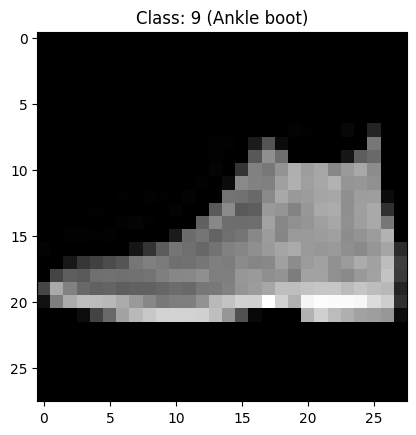

In [17]:
x = x.cpu()
x = x.squeeze(dim=0)

fig, ax = plt.subplots()
ax.imshow(x, cmap="gray")
ax.set_title(f"Class: {y} ({classes[y]})")